# Inference

In this notebook we will demonstrate how to use two pretrained models to generate multitrack mixes of drum recordings. We provide models trained on the ENST-drums dataset, which features a few hundred drums multitracks and mixes of these multitracks made by professional audio engineers. We train two different multitrack mixing model architectures: the Differentiable Mixing Console (DMC), and the MixWaveUNet. First we will download the model checkpoints and some test audio, then load up the models and the audio tracks and generate a mix that we can listen to. 

Note: This notebook assumes that you have already installed the `automix` package. If you have not done so, you can run the following.

`pip install git+https://github.com/csteinmetz1/automix-toolkit`

In [2]:
import os
import glob
import torch
import torchaudio
import numpy as np

import IPython
import IPython.display as ipd
import matplotlib.pyplot as plt
import librosa.display

%matplotlib inline
%load_ext autoreload
%autoreload 2

from automix.system import System

## Download the pretrained models and drum multitrack
First we will download two different pretrained models. Then we will also download a `.zip` file containing a drum multitrack from the test dataset that unseen during training. 

In [3]:
# download the pretrained models for DMC and MixWaveUNet trained on ENST-drums dataset
os.makedirs("checkpoints", exist_ok=True)
!wget https://huggingface.co/csteinmetz1/automix-toolkit/resolve/main/enst-drums-dmc.ckpt
!wget https://huggingface.co/csteinmetz1/automix-toolkit/resolve/main/enst-drums-mixwaveunet.ckpt
!mv enst-drums-dmc.ckpt checkpoints/enst-drums-dmc.ckpt
!mv enst-drums-mixwaveunet.ckpt checkpoints/enst-drums-mixwaveunet.ckpt

# then download and extract a drum multitrack from the test set
!wget https://huggingface.co/csteinmetz1/automix-toolkit/resolve/main/drums-test-rock.zip
!unzip -o drums-test-rock.zip

--2022-11-28 08:10:05--  https://huggingface.co/csteinmetz1/automix-toolkit/resolve/main/enst-drums-dmc.ckpt
Resolving huggingface.co (huggingface.co)... 2600:1f18:147f:e800:3df1:c2fc:20aa:9b45, 2600:1f18:147f:e850:fad3:e054:c752:ff16, 34.227.196.80, ...
Connecting to huggingface.co (huggingface.co)|2600:1f18:147f:e800:3df1:c2fc:20aa:9b45|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://cdn-lfs.huggingface.co/repos/ec/ee/ecee38df047e3f2db1bd8c31a742f3a08f557470cd67cb487402a9c3ed91b5ea/02988c14c2aeee899dc44488f61c58ca6902e3d815931e6fdd5edda969f70f18?response-content-disposition=attachment%3B%20filename%3D%22enst-drums-dmc.ckpt%22&Expires=1669882206&Policy=eyJTdGF0ZW1lbnQiOlt7IlJlc291cmNlIjoiaHR0cHM6Ly9jZG4tbGZzLmh1Z2dpbmdmYWNlLmNvL3JlcG9zL2VjL2VlL2VjZWUzOGRmMDQ3ZTNmMmRiMWJkOGMzMWE3NDJmM2EwOGY1NTc0NzBjZDY3Y2I0ODc0MDJhOWMzZWQ5MWI1ZWEvMDI5ODhjMTRjMmFlZWU4OTlkYzQ0NDg4ZjYxYzU4Y2E2OTAyZTNkODE1OTMxZTZmZGQ1ZWRkYTk2OWY3MGYxOD9yZXNwb25zZS1jb250ZW50LWRpc3Bvc2l

HTTP request sent, awaiting response... 200 OK
Length: 20044145 (19M) [application/zip]
Saving to: ‘drums-test-rock.zip.1’

drums-test-rock.zip 100%[===================>]  19.12M  17.0MB/s    in 1.1s    

2022-11-28 08:10:21 (17.0 MB/s) - ‘drums-test-rock.zip.1’ saved [20044145/20044145]

Archive:  drums-test-rock.zip
  inflating: __MACOSX/._drums-test-rock  
  inflating: drums-test-rock/.DS_Store  
  inflating: __MACOSX/drums-test-rock/._.DS_Store  
  inflating: drums-test-rock/tracks/04_overhead_L_066_phrase_rock_complex_fast_sticks.wav  
  inflating: drums-test-rock/tracks/01_kick_066_phrase_rock_complex_fast_sticks.wav  
  inflating: drums-test-rock/tracks/03_hi-hat_066_phrase_rock_complex_fast_sticks.wav  
  inflating: drums-test-rock/tracks/02_snare_066_phrase_rock_complex_fast_sticks.wav  
  inflating: drums-test-rock/tracks/07_tom_2_066_phrase_rock_complex_fast_sticks.wav  
  inflating: drums-test-rock/tracks/06_tom_1_066_phrase_rock_complex_fast_sticks.wav  
  inflating: drums

## Set configuration
We have the option to select one of two different checkpoints. 

If we select `enst-drums-dmc.ckpt` we can use the pretrained Differentiable mixing console model which will directly predict gain and panning parameters for each track. On the other hand we can also select `enst-drums-mixwaveunet.ckpt` which will use a multi-input WaveUNet to create a mix of the tracks. To make computation faster we can restrict the maximum number of samples the process with `max_samples`. Using the default `max_samples = 262144` will mix about the first 6 seconds of the track. You can try increasing this value to see how the results change. 

Note: In the case of MixWaveUNet, a power of 2 value for `max_samples` is required.

In [12]:
track_dir = "./drums-test-rock/tracks"
track_ext = "wav"

dmc_ckpt_path = "checkpoints/enst-drums-dmc.ckpt"
mwun_ckpt_path = "checkpoints/enst-drums-mixwaveunet.ckpt"

max_samples = 262144

## Load pretrained model


In [13]:
# load pretrained model
dmc_system = System.load_from_checkpoint(dmc_ckpt_path, pretrained_encoder=False, map_location="cpu").eval()
mwun_system = System.load_from_checkpoint(mwun_ckpt_path, map_location="cpu").eval()

## Load multitrack 
Now we will read the tracks from disk and create a tensor with all the tracks. In this case, we first peak normalize each track to -12 dB which is what the models expect. In the case of MixWaveUNet, we will add an extra track of silence if less than 8 are provided. However, the DMC model can accept any number of tracks, wether more or less than it was trained with.

We can also create a simple mono mixture of these tracks to hear what the multitrack sounds like before we do any mixing. 

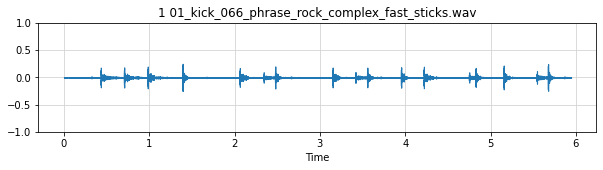

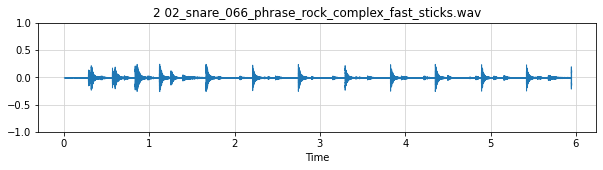

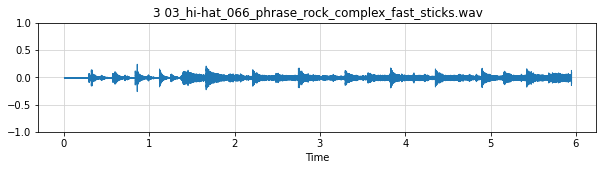

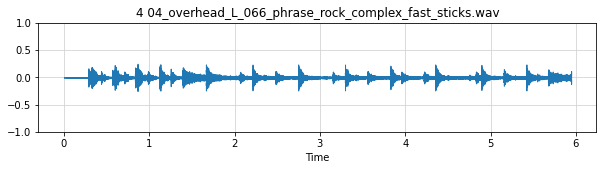

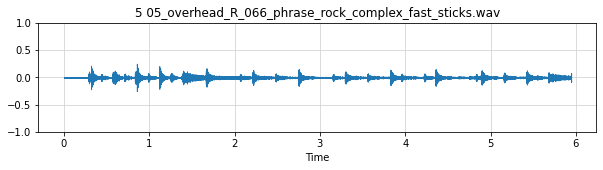

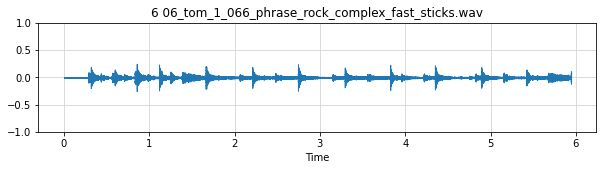

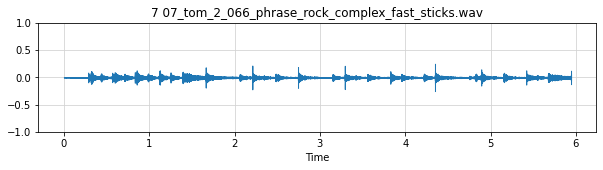

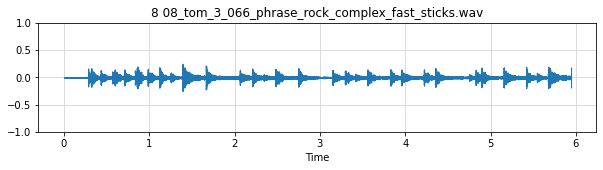

torch.Size([1, 1, 262144])


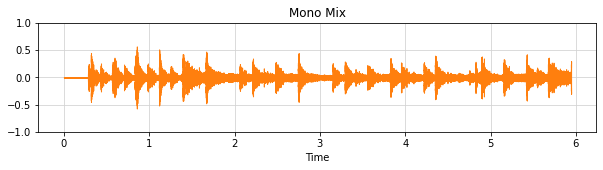

In [27]:
# load the input tracks
track_filepaths = glob.glob(os.path.join(track_dir, f"*.{track_ext}"))
track_filepaths = sorted(track_filepaths)
tracks = []
for idx, track_filepath in enumerate(track_filepaths):
    x, sr = torchaudio.load(track_filepath)
    x = x[:, : max_samples]
    x /= x.abs().max().clamp(1e-8) # peak normalize
    x *= 10 ** (-12/20.0) # set peak to -12 dB
    tracks.append(x)

    plt.figure(figsize=(10, 2))
    librosa.display.waveshow(x.view(1,-1).numpy(), sr=sr, zorder=3)
    plt.title(f"{idx+1} {os.path.basename(track_filepath)}")
    plt.ylim([-1,1])
    plt.grid(c="lightgray")
    plt.show()
    IPython.display.display(ipd.Audio(x.view(1,-1).numpy(), rate=sr, normalize=True))    

# add dummy tracks of silence if needed
if system.hparams.automix_model == "mixwaveunet" and len(tracks) < 8:
    tracks.append(torch.zeros(x.shape))

# stack tracks into a tensor
tracks = torch.stack(tracks, dim=0)
tracks = tracks.permute(1, 0, 2)
# tracks have shape (1, num_tracks, seq_len)

# listen to the input (mono) before mixing
input_mix = tracks.sum(dim=1, keepdim=True)
print(input_mix.shape)
plt.figure(figsize=(10, 2))
plt.title("Mono Mix")
librosa.display.waveshow(input_mix.view(1,-1).numpy(), sr=sr, zorder=3, color="tab:orange")
plt.ylim([-1,1])
plt.grid(c="lightgray")
plt.show()
IPython.display.display(ipd.Audio(input_mix.view(1,-1).numpy(), rate=sr, normalize=False))

## Generate the DMC mix
Now we can listen to the predicted mix. If we create a mix with the differentiable mixing console we can also print out the gain (in dB) and pan parameter for each track.

torch.Size([1, 2, 262144]) torch.Size([1, 8, 2])


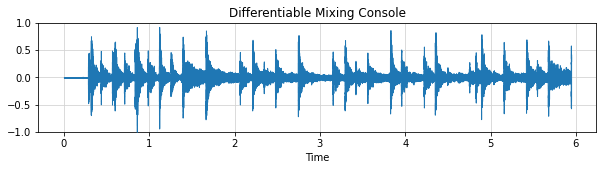

In [28]:
# pass tracks to the model and create a mix
with torch.no_grad(): # no need to compute gradients
    mix, params = dmc_system(tracks)
print(mix.shape, params.shape)

# view the mix
mix /= mix.abs().max()
plt.figure(figsize=(10, 2))
plt.title("Differentiable Mixing Console")
librosa.display.waveshow(mix.view(2,-1).numpy(), sr=sr, zorder=3)
plt.ylim([-1,1])
plt.grid(c="lightgray")
plt.show()
IPython.display.display(ipd.Audio(mix.view(2,-1).numpy(), rate=sr, normalize=True))

if system.hparams.automix_model == "dmc":
    for track_fp, param in zip(track_filepaths, params.squeeze()):
        print(os.path.basename(track_fp), param)

## Generate the Mix-Wave-U-Net Mix
If we use the MixWaveUNet there are no parameters to show since this model uses a *direct transformation* method which does not use intermediate mixing parameters. 

torch.Size([1, 2, 262144]) torch.Size([1])


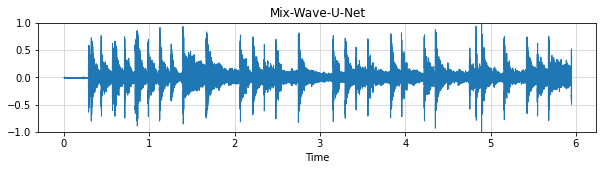

In [21]:
with torch.no_grad(): # no need to compute gradients
    mwun_mix, params = mwun_system(tracks)
print(mix.shape, params.shape)

# view the mix
mwun_mix /= mwun_mix.abs().max()
plt.figure(figsize=(10, 2))
plt.title("Mix-Wave-U-Net")
librosa.display.waveshow(mwun_mix.view(2,-1).numpy(), sr=sr, zorder=3)
plt.ylim([-1,1])
plt.grid(c="lightgray")
plt.show()
IPython.display.display(ipd.Audio(mwun_mix.view(2,-1).numpy(), rate=sr, normalize=True))